In [96]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [97]:
import sys
sys.path.append("..")
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
from example_systems import generate_mackey_glass_system
tau = 30
dt = 1.0
mg_system_gt = generate_mackey_glass_system(tau, dt=0.5)

In [99]:
from helpers import vec

timesteps = np.arange(0.0, 300, step=mg_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, tau+1, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 1, 1))

states_gt[0] = np.zeros((tau+1, 1)) + 1.0

# cart acceleration schedule
t = np.min(np.argwhere(timesteps > 1.0))
controls = timesteps

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = mg_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = mg_system_gt.query_measurement_model(x_next)
    measurements[t] = z


  3%|▎         | 17/599 [00:00<00:03, 168.49it/s]

100%|██████████| 599/599 [00:02<00:00, 201.62it/s]


In [100]:
# Test all filters on same system model approximation
subsample = 5          # filters run at a fraction of sampling rate of the simulation
timesteps_sub = timesteps[::subsample]
states_gt_sub = states_gt[::subsample]
measurements_sub = measurements[::subsample]
controls_sub = controls[::subsample]
T_sub = len(timesteps_sub)

mg_system_approx = generate_mackey_glass_system(tau, dt=mg_system_gt.delta_t * subsample)

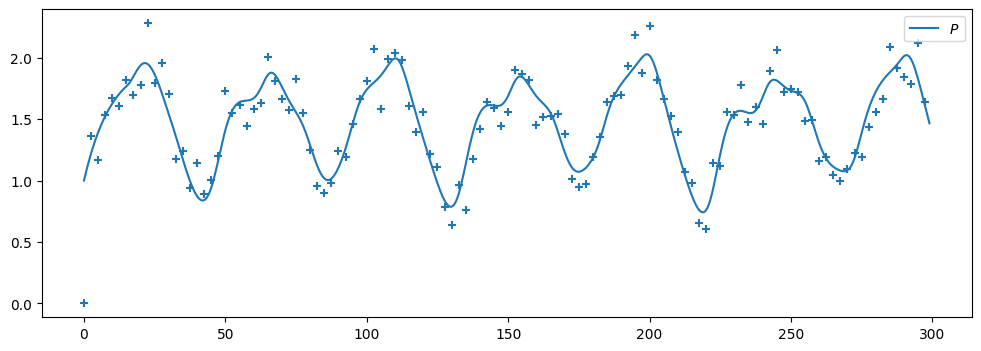

In [101]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,0,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

P_gt = states_gt[:t_max,0,0]

fig, ax = plt.subplots(figsize=(12, 4))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], P_gt, label=r"$P$")
ax.scatter(timesteps_sub, measurements_sub, marker="+")
ax.legend(ncol=2)

In [102]:
# Test all filters with the same initial belief
initial_covariance = np.eye(mg_system_gt.state_dim)
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)

initial_state_estimate = (initial_mean, initial_covariance)
# initial_state_estimate

In [103]:
def plot_filter_results(mean, filter_name): # Needs to be updated for this system
    fig, (ax1) = plt.subplots(figsize=(12, 4))
    fig.suptitle(f"Filtering Results: {filter_name}")

    ax1.set_xlabel("time")
    ax1.plot(timesteps_sub, states_gt_sub[:,0,0], label="gt")
    ax1.plot(timesteps_sub, mean, label=filter_name)
    # ax1.set_xlim([0, 800])
    ax1.set_ylim([0, 2.5])

    ax1.legend()

100%|██████████| 119/119 [00:01<00:00, 95.59it/s] 


Range Complete!


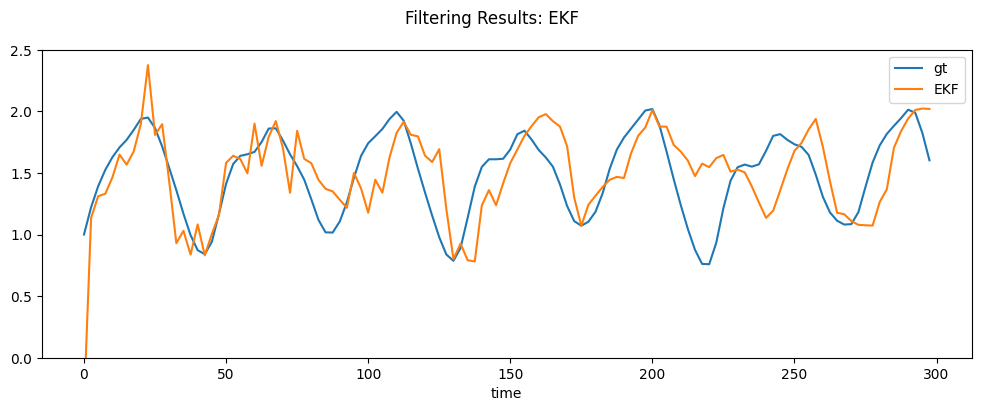

In [104]:
# Run the EKF

from filters import ExtendedKalmanFilter

mg_EKF = ExtendedKalmanFilter(mg_system_approx)

# initial state belief
mg_EKF.initialize(initial_mean,initial_covariance)

means_EKF = np.zeros((T_sub, tau+1, 1))
covariances_EKF = np.zeros((T_sub, tau+1, tau+1))

means_EKF[0] = mg_EKF.mean
covariances_EKF[0] = mg_EKF.covariance

for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_EKF.predict_step(u)
    mg_EKF.update_step(z)
    
    means_EKF[t] = mg_EKF.mean
    covariances_EKF[t] = mg_EKF.covariance

print("Range Complete!")

# Plot results
#print(means_EKF[:,0,0])
plot_filter_results(means_EKF[:,0,0], "EKF")

100%|██████████| 119/119 [00:28<00:00,  4.16it/s]


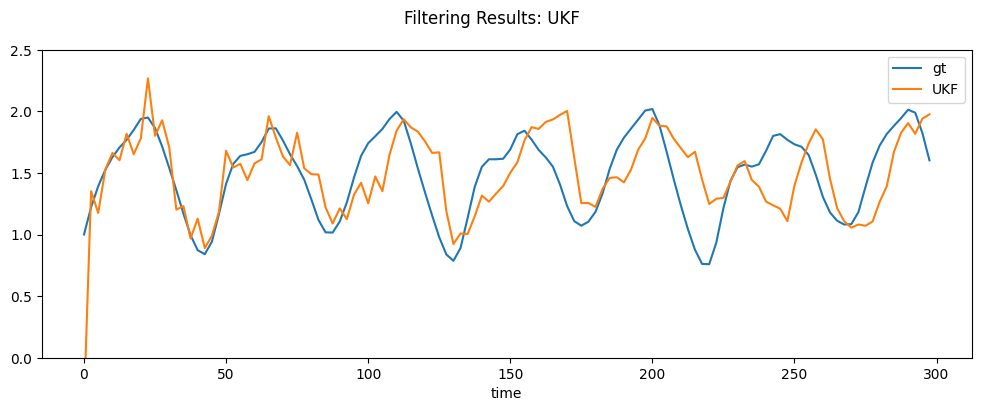

In [105]:
# Run the UKF

from filters import UnscentedKalmanFilter
mg_UKF = UnscentedKalmanFilter(mg_system_approx)

# initial state belief
mg_UKF.initialize(initial_mean,initial_covariance)

means_UKF = np.zeros((T_sub, tau+1, 1))
covariances_UKF = np.zeros((T_sub, tau+1, tau+1))

means_UKF[0] = mg_UKF.mean
covariances_UKF[0] = mg_UKF.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF.predict_step(u)
    mg_UKF.update_step(z)

    means_UKF[t] = mg_UKF.mean
    covariances_UKF[t] = mg_UKF.covariance


# Plot results
plot_filter_results(means_UKF[:,0,0], "UKF")

In [106]:
# Run the UKF Variant

from probability.sigma_points import MultiShellSigmaPointSelector

mg_UKF2 = UnscentedKalmanFilter(
    mg_system_approx,
    sigma_point_selector=MultiShellSigmaPointSelector([0.1, 0.5])
)

# initial state belief
mg_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T_sub, tau+1, 1))
covariances_UKF2 = np.zeros((T_sub, tau+1, tau+1))

means_UKF2[0] = mg_UKF2.mean
covariances_UKF2[0] = mg_UKF2.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF2.predict_step(u)
    mg_UKF2.update_step(z)

    means_UKF2[t] = mg_UKF2.mean
    covariances_UKF2[t] = mg_UKF2.covariance


# Plot results
#plot_filter_results(means_UKF2, "UKF2")

100%|██████████| 119/119 [00:55<00:00,  2.13it/s]


In [107]:
# Error Analysis

errors_EKF = means_EKF - states_gt_sub
errors_UKF = means_UKF - states_gt_sub
errors_UKF2 = means_UKF2 - states_gt_sub

print("EKF Error: ", np.mean(np.linalg.norm(errors_EKF, axis=1)))
print("UKF Error: ", np.mean(np.linalg.norm(errors_UKF, axis=1)))
print("UKF2 Error:", np.mean(np.linalg.norm(errors_UKF2, axis=1)))

EKF Error:  2.9218932023416855
UKF Error:  2.936111521600302
UKF2 Error: 2.862523107158759
